In [53]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM, Dense
import keras
import pandas as pd

In [ ]:
# 데이터 불러오기
data = pd.read_csv('/home/siwon/dev/Deeplearning-6/data/trajectory_dataset_transformed.csv')
data = data.iloc[:, :4]  # 데이터의 첫 4개 열만 사용

# 입력 데이터와 타겟 데이터로 나누기
input_data = []
target_data = []

# 각 id 그룹에 대해 반복
for group_id in data['id'].unique():
    group_data = data[data['id'] == group_id].reset_index(drop=False)
    num_samples = len(group_data) # group_datat : 각 id에 대하는 좌표들의 갯수


    # 각 그룹 내에서 5개의 연속된 데이터를 입력으로, 그 다음 데이터의 좌표를 타겟으로 사용
    for i in range(5, num_samples):
        input_data.append(group_data.iloc[i-5:i][['x', 'y','t']].to_numpy())
        target_data.append(group_data.iloc[i][['x', 'y','t']].to_numpy())

# numpy 배열로 변환
input_data = np.array(input_data)
target_data = np.array(target_data)

# 학습용과 검증용으로 데이터를 나눔
train_input, test_input, train_target, test_target = train_test_split(input_data, target_data, test_size=0.2, random_state=42)

In [ ]:
# LSTM 모델 만들기
model = Sequential()
model.add(LSTM(32, input_shape=(5, 3), return_sequences=True))
model.add(LSTM(64, return_sequences=True))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(3))

# 모델 컴파일
model.compile(loss='mse', optimizer='adam')

# EarlyStopping 콜백 설정
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

# 모델 학습
history = model.fit(input_data, target_data, epochs=1000, batch_size=16, validation_split=0.2)

In [ ]:
# 모델 저장
model.save('/home/siwon/dev/Deeplearning-6/model/first_model.h5')

In [51]:
## model load
from keras.models import load_model
model = load_model('/home/siwon/dev/Deeplearning-6/model/first_model.h5')

2023-04-24 17:08:33.696320: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-24 17:08:33.697711: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-24 17:08:33.698569: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [52]:
# 학습 과정 시각화
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.      history['val_loss'], label='val_loss')
plt.legend()
plt.show()

NameError: name 'history' is not defined

1/1 [==============================] - 0s 214ms/step


2023-04-24 17:08:40.316016: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-24 17:08:40.316998: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-24 17:08:40.317720: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

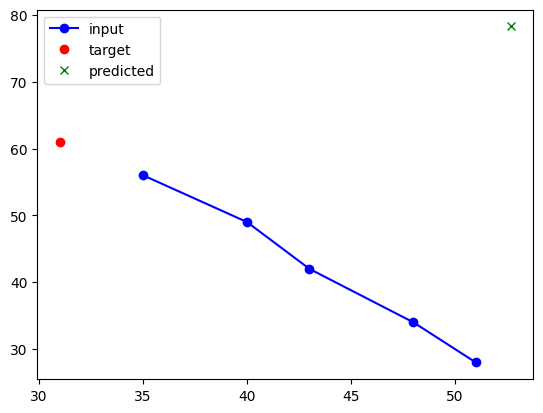

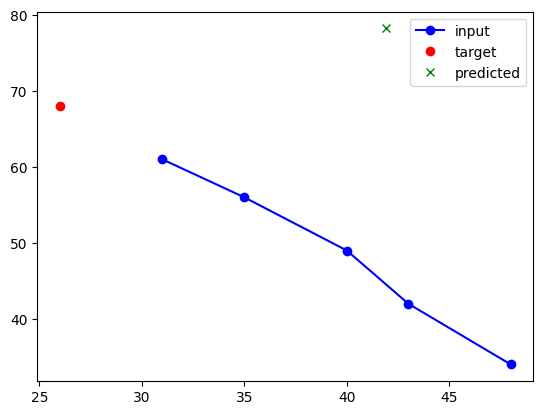

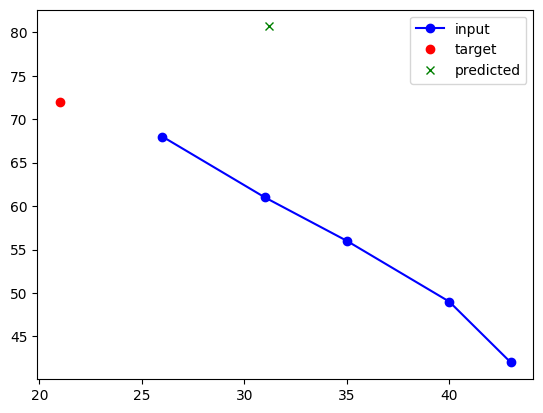

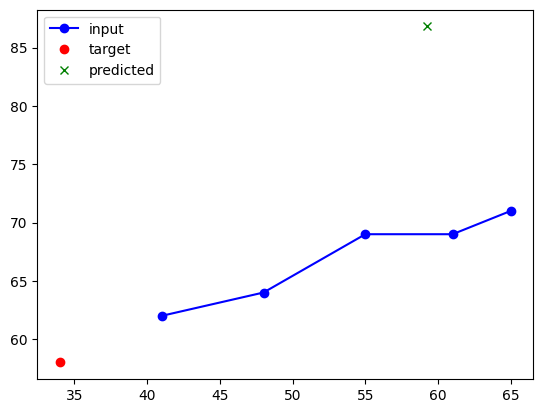

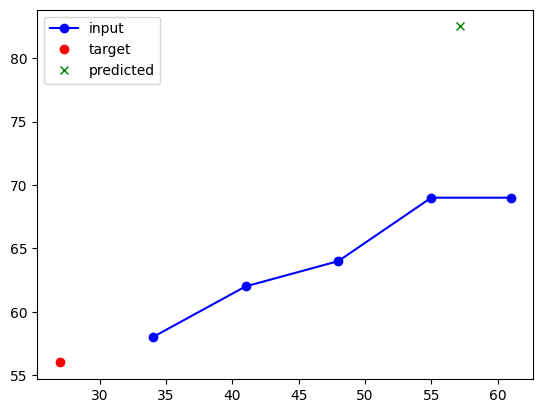

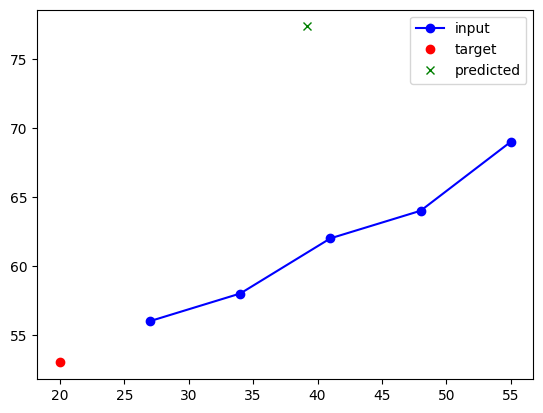

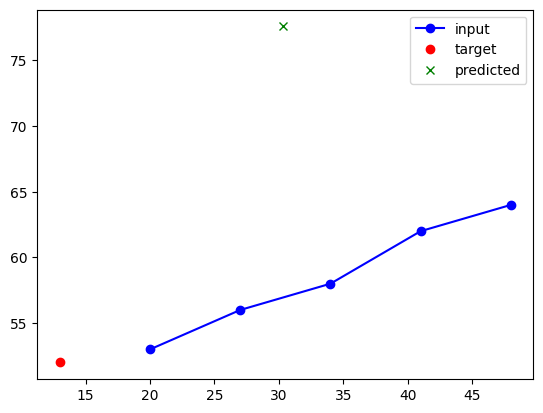

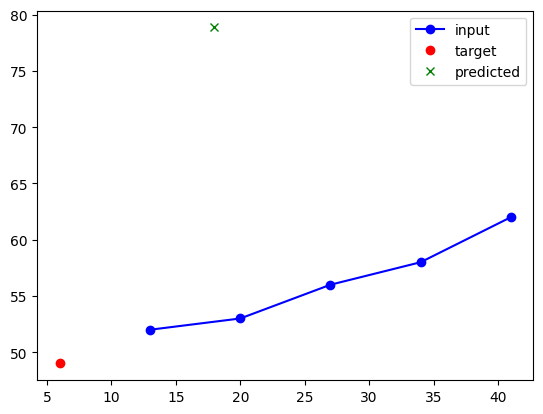

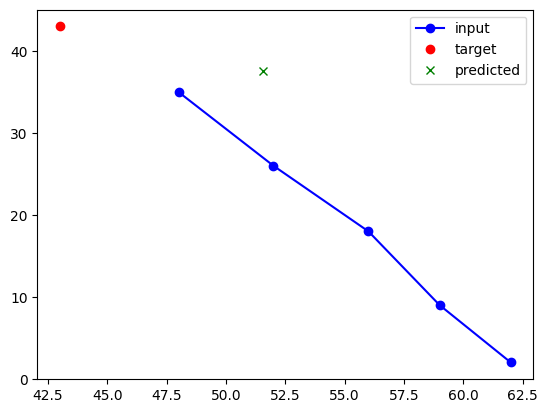

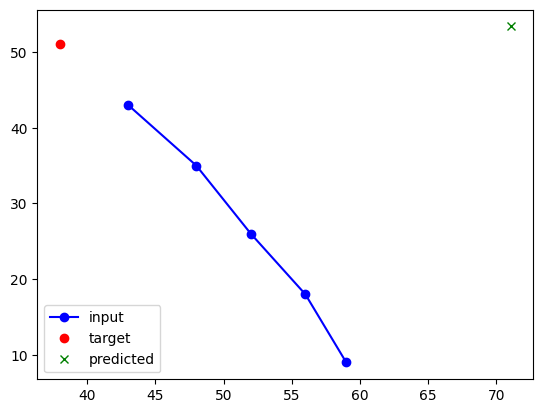

In [54]:
# 테스트 데이터 예측
test_input = input_data[10:30]
test_target = target_data[10:30]
predicted = model.predict(test_input)

# 예측 결과 시각화
for i in range(10):
    plt.plot(test_input[i, :, 0], test_input[i, :, 1], 'bo-', label='input')
    plt.plot(test_target[i, 0], test_target[i, 1], 'ro', label='target')
    plt.plot(predicted[i, 0], predicted[i, 1], 'gx', label='predicted')
    plt.legend()
    plt.show()

In [ ]:
test_target = target_data[3412:3433]
print(test_target, "\n----\n", len(test_target))

1/1 [==============================] - 0s 17ms/step


ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 2, the array at index 0 has size 3 and the array at index 1 has size 2

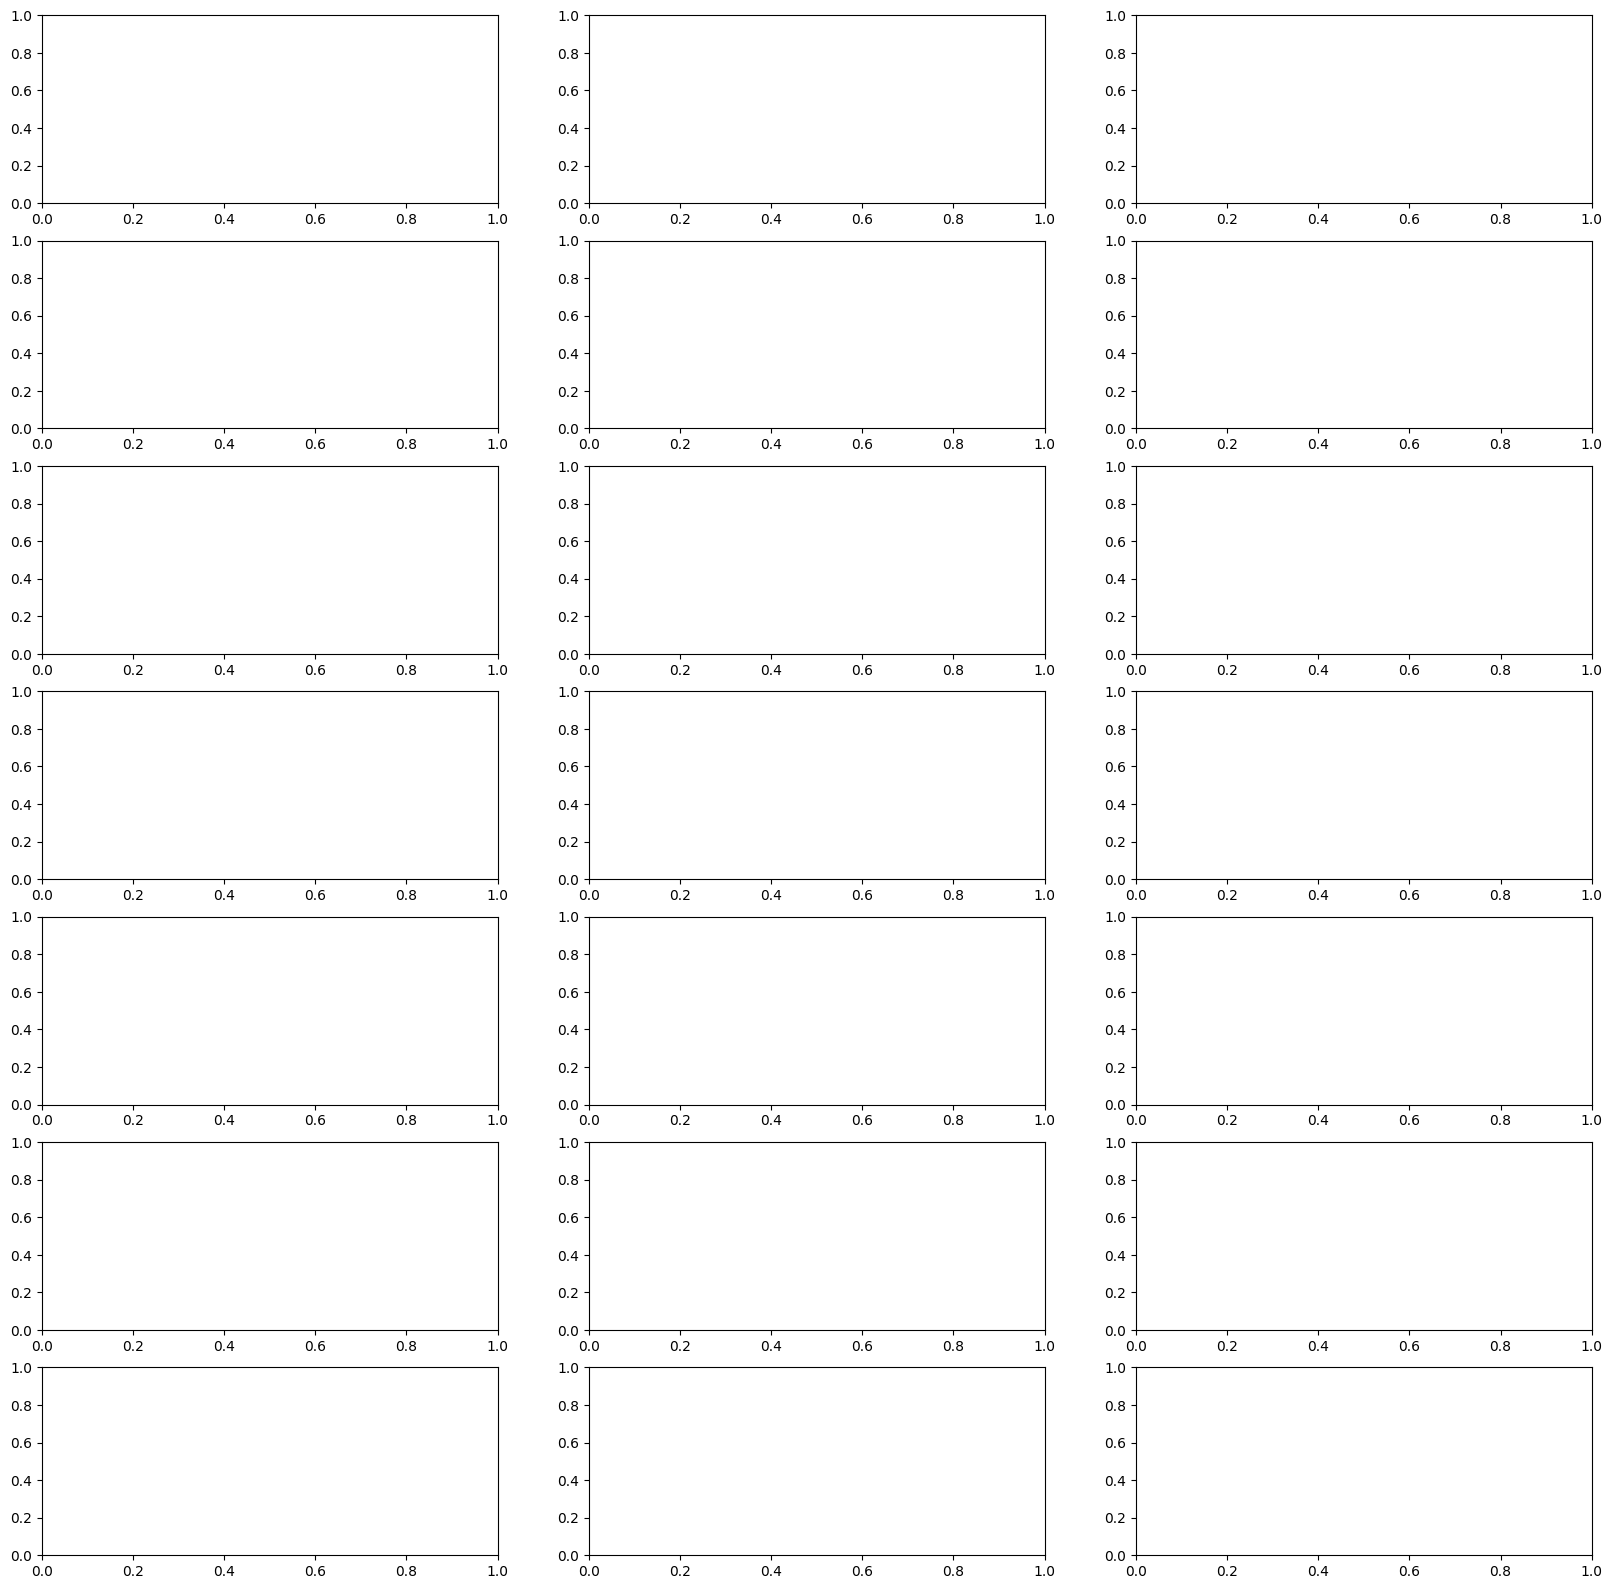

In [55]:
# 주어진 입력 데이터에서 연속적으로 다음 위치 예측 함수
def predict_next_positions(model, input_data, num_steps):
    current_input = input_data.copy()
    predicted_positions = []

    for _ in range(num_steps):
        predicted = model.predict(current_input)
        predicted_positions.append(predicted[0])

        # 처음 4개 좌표와 예측한 좌표로 새로운 입력 데이터 생성
        new_input = np.concatenate((current_input[:, 1:, :], predicted.reshape(1, 1, -1)), axis=1)
        current_input = new_input

    return np.array(predicted_positions)

# 테스트 데이터 예측
test_input = input_data[3412:3433]
test_target = target_data[3412:3433]

# 예측할 위치의 개수
num_steps = 5

fig, axes = plt.subplots(7, 3, figsize=(20, 20))
axes = axes.ravel()

for i in range(21):
    # 테스트 데이터를 사용하여 연속적으로 다음 위치 예측
    predicted_positions = predict_next_positions(model, test_input[i:i+1], num_steps)

    axes[i].plot(test_input[i, :, 0], test_input[i, :, 1], 'bo-', label='input')


    for j, predicted in enumerate(predicted_positions):
        axes[i].plot(predicted[0], predicted[1], 'gx', label='predicted' if j == 0 else '')
        #axes[i].text(predicted[0], predicted[1], '{}'.format(j + 1), fontsize=10, color='black', verticalalignment='bottom', horizontalalignment='right')
        if j == 0:
            # 처음 예측값이면 선을 파랑색 마지막부터 이음 
            continue
        # 이전 예측값과 현재 예측값을 연결하는 선을 그림
        prev_predicted = predicted_positions[j-1]
        axes[i].plot([prev_predicted[0], predicted[0]], [prev_predicted[1], predicted[1]], 'g--')

    for j, target in enumerate(test_target[i:i+num_steps]):
        axes[i].plot(target[0], target[1], 'ro', label='target' if j == 0 else '')
        target_label = target[2] + 1
        axes[i].text(target[0], target[1], target_label, fontsize=10, color='black', verticalalignment='bottom', horizontalalignment='right')
        if j == 0:
            # 처음 예측값이면 선을 파랑색 마지막부터 이음 
            continue
        prev_targeted = test_target[j-1]
        

    axes[i].plot((test_input[i, 4, 0], predicted_positions[0][0]), (test_input[i, 4, 1],predicted_positions[0][1]), '--')
    axes[i].set_xlim([0, 72])
    axes[i].set_ylim([0, 72])
    axes[i].set_title('Case {}'.format(i + 1))
    axes[i].legend()

plt.tight_layout()
plt.show()


1/1 [==============================] - 0s 18ms/step


ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 2, the array at index 0 has size 3 and the array at index 1 has size 2

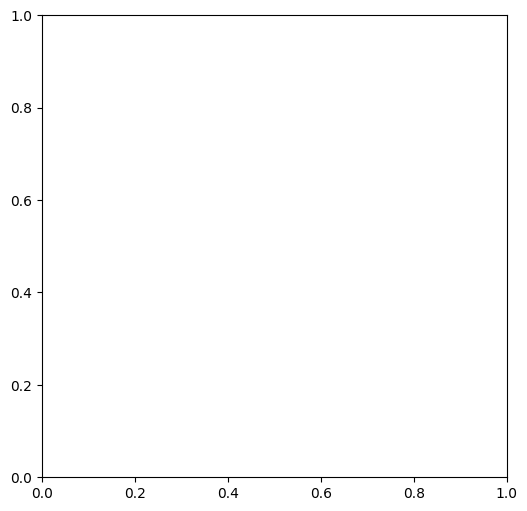

In [56]:
import imageio
from IPython.display import Image

# 이미지를 저장할 디렉토리 생성
import os
if not os.path.exists('images'):
    os.makedirs('images')

# 움짤 생성 함수
def create_gif(filenames, output_file, duration=0.5):
    images = [imageio.imread(filename) for filename in filenames]
    imageio.mimsave(output_file, images, duration=duration)

# 움짤로 만들 그래프 이미지 저장
filenames = []

for i in range(21):
    fig, ax = plt.subplots(figsize=(6, 6))
    predicted_positions = predict_next_positions(model, test_input[i:i+1], num_steps)

    ax.plot(test_input[i, :, 0], test_input[i, :, 1], 'bo-', label='input')

    for j, predicted in enumerate(predicted_positions):
        ax.plot(predicted[0], predicted[1], 'gx', label='predicted' if j == 0 else '')
        if j == 0:
            continue
        prev_predicted = predicted_positions[j-1]
        ax.plot([prev_predicted[0], predicted[0]], [prev_predicted[1], predicted[1]], 'g--')

    for j, target in enumerate(test_target[i:i+num_steps]):
        ax.plot(target[0], target[1], 'ro', label='target' if j == 0 else '')
        target_label = target[2] + 1
        ax.text(target[0], target[1], target_label, fontsize=10, color='black', verticalalignment='bottom', horizontalalignment='right')
        if j == 0:
            continue
        prev_targeted = test_target[j-1]

    ax.plot((test_input[i, 4, 0], predicted_positions[0][0]), (test_input[i, 4, 1],predicted_positions[0][1]), '--')
    ax.set_xlim([0, 72])
    ax.set_ylim([0, 72])
    ax.set_title('Case {}'.format(i + 1))
    ax.legend()

    # 이미지 저장
    filename = f'images/case_{i + 1}.png'
    filenames.append(filename)
    fig.savefig(filename)
    plt.close(fig)

# 움짤 생성
create_gif(filenames, 'output.gif', duration=0.5)

# 움짤 표시
Image(filename="output.gif")
